In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy import signal
import xesmf as xe
 
from mlprecip_utils import *
from mlprecip_models import *
from mlprecip_xai import *
from mlprecip_plot import *

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.
/homes/kpegion/.conda/envs/ml-precip/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/homes/kpegion/.conda/envs/ml-precip/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/homes/kpegion/.conda/envs/ml-precip/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/homes/kpegion

In [2]:
varname='precip'
model_types=['logmodel_med']

# Define Winter and Summer Months
winter=[12,1,2]
summer=[6,7,8]

target_dataset='era5-precip'
#target_dataset='era-interim-precip'

### Read in train and test data

In [3]:
ds_features_tval=xr.open_dataset('../data/cnn/features_trainval.nc')
ds_target_tval=xr.open_dataset('../data/cnn/'+target_dataset+'/target_trainval.nc')

In [4]:
ds_features_tval

<xarray.Dataset>
Dimensions:    (time: 55520, lat: 37, lon: 72)
Coordinates:
    level      float32 ...
  * lon        (lon) int64 0 5 10 15 20 25 30 35 ... 325 330 335 340 345 350 355
  * lat        (lat) int64 -90 -85 -80 -75 -70 -65 -60 ... 60 65 70 75 80 85 90
  * time       (time) datetime64[ns] 1979-01-01 ... 2016-12-31T18:00:00
    dayofyear  (time) int64 ...
Data variables:
    z500       (time, lat, lon) float64 ...
    z850       (time, lat, lon) float64 ...
    u200       (time, lat, lon) float64 ...
    u850       (time, lat, lon) float64 ...
    olr        (lat, time, lon) float64 ...
    sst        (time, lat, lon) float64 ...

### Main Program to Train Models

Winter
logmodel_med
<xarray.Dataset>
Dimensions:    (time: 3430, lat: 37, lon: 72)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2016-12-31
    level      float32 500.0
  * lon        (lon) int64 0 5 10 15 20 25 30 35 ... 325 330 335 340 345 350 355
  * lat        (lat) int64 -90 -85 -80 -75 -70 -65 -60 ... 60 65 70 75 80 85 90
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365 366
Data variables:
    z500       (time, lat, lon) float64 1.199e+03 1.199e+03 ... 737.3 737.3
    z850       (time, lat, lon) float64 404.8 404.8 404.8 ... 1.14e+03 1.14e+03
    u200       (time, lat, lon) float64 2.256 2.256 2.256 ... -0.7589 -0.7589
    u850       (time, lat, lon) float64 1.762 1.762 1.762 ... 0.4329 0.4329
    olr        (lat, time, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    sst        (time, lat, lon) float64 0.0 0.0 0.0 ... -0.0004573 -0.0004573
<xarray.Dataset>
Dimensions:    (time: 3430)
Coordinates:
  * time       (ti

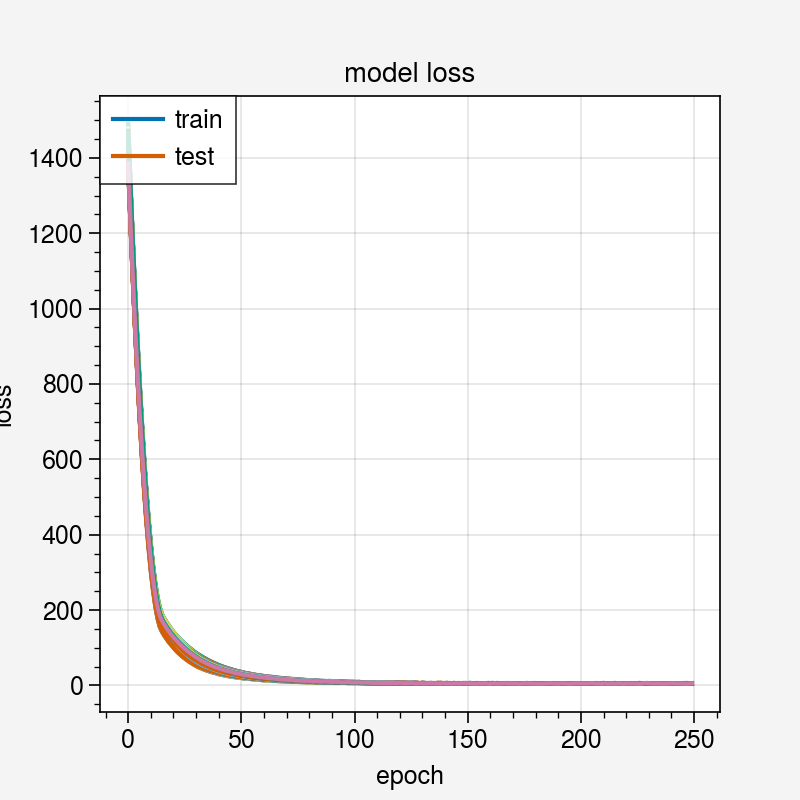

In [5]:
# Loop over seasons
#for seas,slabel,seas_abbrv in zip([winter,summer],['Winter','Summer'],['DJF','JJA']):
for seas,slabel,seas_abbrv in zip([winter],['Winter'],['DJF']):
#for seas,slabel,seas_abbrv in zip([summer],['Summer'],['JJA']):
    
    print(slabel)
                   
    # Select season from target precip anomalies
    ds_i=ds_target_tval.sel(time=ds_target_tval['time.month'].isin(seas)) 
    
    # Make sure we have the same times for target and features
    ds_t,ds_f=xr.align(ds_i.dropna(dim='time'),
                       ds_features_tval.dropna(dim='time'),
                       join='inner')

    # Subtract the median to ensure data is centered and classes are equal
    median=np.percentile(ds_t[varname],50)
    ds_t[varname]=ds_t[varname]-median
     
    #----- TRAIN MODELS  -----------#
    # Define number of models to fit
    nmodels=100
     
    # Loop over Model Types    
    for m_function in model_types:
        print(m_function)
        fname='../data/cnn/'+target_dataset+'/models/seus.median.'+seas_abbrv+'.'+m_function
        ofname='../data/cnn/'+target_dataset+'/output/model_output.'+seas_abbrv+'.'+m_function
        trainIndexModels(m_function,ds_f,
                         ds_t,varname,nmodels,fname=fname,ofname=ofname)
        
        